Original Category Distribution:
 category
Politics/News       2171
Lifestyle           1665
Health/Lifestyle    1304
Entertainment       1258
Family               930
Social Issues        907
Crime/Other          901
Business             396
Sports               245
Tech                 223
Name: count, dtype: int64
Resampled Category Distribution:
 category
Social Issues       2171
Business            2171
Politics/News       2171
Crime/Other         2171
Tech                2171
Family              2171
Health/Lifestyle    2171
Lifestyle           2171
Entertainment       2171
Sports              2171
Name: count, dtype: int64
Epoch 1/100
435/435 [==============================] - 10s 19ms/step - loss: 1.8483 - accuracy: 0.4271 - val_loss: 1.1620 - val_accuracy: 0.7168 - lr: 5.0000e-04
Epoch 2/100
435/435 [==============================] - 7s 16ms/step - loss: 0.9369 - accuracy: 0.7966 - val_loss: 0.9372 - val_accuracy: 0.8129 - lr: 5.0000e-04
Epoch 3/100
435/435 [===================

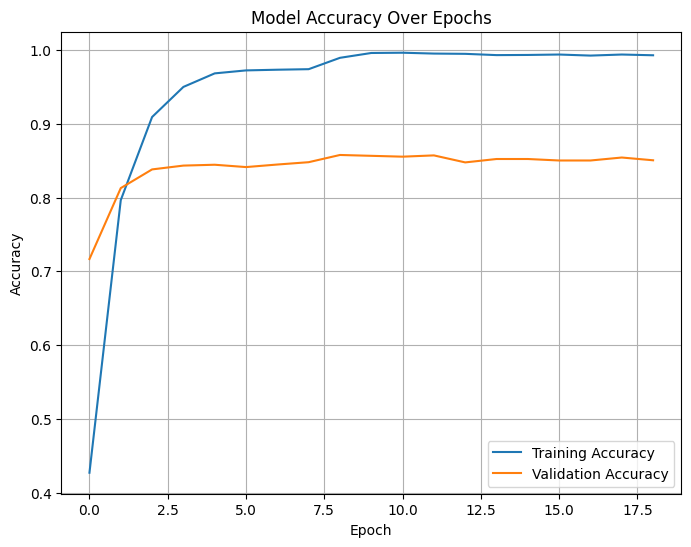

136/136 [==============================] - 1s 4ms/step


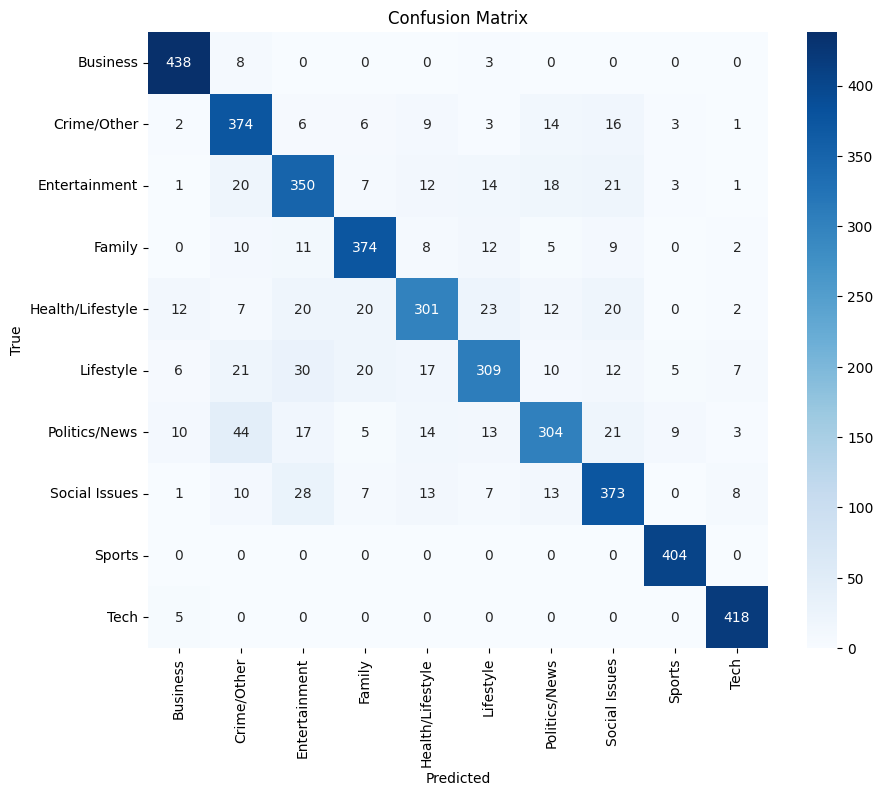


Predictions on New Headlines:
1/1 [==============================] - 0s 22ms/step
Headline: 'Team wins championship game'
Predicted Category: Sports (Confidence: 99.51%)

1/1 [==============================] - 0s 22ms/step
Headline: 'New law sparks heated debate'
Predicted Category: Politics/News (Confidence: 98.80%)

1/1 [==============================] - 0s 30ms/step
Headline: 'Tech giant unveils latest gadget'
Predicted Category: Crime/Other (Confidence: 36.82%)

1/1 [==============================] - 0s 22ms/step
Headline: 'Parenting tips for raising teenagers successfully'
Predicted Category: Family (Confidence: 99.91%)

1/1 [==============================] - 0s 19ms/step
Headline: 'Latest smartphone features revolutionize mobile gaming'
Predicted Category: Business (Confidence: 85.80%)



In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load and sample data
df = pd.read_json("./News_Category_Dataset_v3.json", lines=True).sample(10000, random_state=42)
X = df["headline"]

# Reduce categories
category_mapping = {
    'POLITICS': 'Politics/News', 'WORLD NEWS': 'Politics/News', 'THE WORLDPOST': 'Politics/News', 'WORLDPOST': 'Politics/News', 'U.S. NEWS': 'Politics/News',
    'WELLNESS': 'Health/Lifestyle', 'HEALTHY LIVING': 'Health/Lifestyle', 'FIFTY': 'Health/Lifestyle',
    'ENTERTAINMENT': 'Entertainment', 'COMEDY': 'Entertainment', 'ARTS & CULTURE': 'Entertainment', 'ARTS': 'Entertainment', 'CULTURE & ARTS': 'Entertainment',
    'SPORTS': 'Sports',
    'TECH': 'Tech', 'SCIENCE': 'Tech',
    'BUSINESS': 'Business', 'MONEY': 'Business',
    'STYLE & BEAUTY': 'Lifestyle', 'STYLE': 'Lifestyle', 'HOME & LIVING': 'Lifestyle', 'FOOD & DRINK': 'Lifestyle', 'TASTE': 'Lifestyle', 'TRAVEL': 'Lifestyle',
    'PARENTING': 'Family', 'PARENTS': 'Family', 'DIVORCE': 'Family', 'WEDDINGS': 'Family',
    'QUEER VOICES': 'Social Issues', 'BLACK VOICES': 'Social Issues', 'LATINO VOICES': 'Social Issues', 'WOMEN': 'Social Issues', 'IMPACT': 'Social Issues',
    'CRIME': 'Crime/Other', 'WEIRD NEWS': 'Crime/Other', 'GOOD NEWS': 'Crime/Other', 'GREEN': 'Crime/Other', 'ENVIRONMENT': 'Crime/Other', 'RELIGION': 'Crime/Other', 'MEDIA': 'Crime/Other', 'EDUCATION': 'Crime/Other', 'COLLEGE': 'Crime/Other'
}
df['category'] = df['category'].map(category_mapping)
y = df['category']
print("Original Category Distribution:\n", df['category'].value_counts())

# Oversample rare classes
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_vec = vectorizer.fit_transform(X).toarray()
ros = RandomOverSampler(random_state=42)
X_reshaped = X_vec.reshape(-1, X_vec.shape[1])
X_resampled, y_resampled = ros.fit_resample(X_reshaped, y)
X_vec = X_resampled
y = pd.Series(y_resampled)
print("Resampled Category Distribution:\n", y.value_counts())

# Split
X_train, X_test, y_train, y_test = train_test_split(X_vec, pd.get_dummies(y), test_size=0.2, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

# DNN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_vec.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dropout(0.25),  # Increased to 0.25
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

# Compile and train
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                    class_weight=class_weight_dict, callbacks=[early_stopping, lr_scheduler], verbose=1)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2%}")

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.values.argmax(axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.columns, yticklabels=y_test.columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Predict on new headlines
def predict_headline(headline, vectorizer, model, category_names):
    headline_cleaned = headline.lower().replace(r'[^\w\s]', '')
    headline_vec = vectorizer.transform([headline_cleaned]).toarray()
    prediction = model.predict(headline_vec)
    predicted_class_idx = prediction.argmax(axis=1)[0]
    predicted_category = category_names[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]
    return predicted_category, confidence

test_headlines = [
    "Team wins championship game",
    "New law sparks heated debate",
    "Tech giant unveils latest gadget",
    "Parenting tips for raising teenagers successfully",
    "Latest smartphone features revolutionize mobile gaming"
]
print("\nPredictions on New Headlines:")
for headline in test_headlines:
    category, confidence = predict_headline(headline, vectorizer, model, y_test.columns)
    print(f"Headline: '{headline}'")
    print(f"Predicted Category: {category} (Confidence: {confidence:.2%})")
    print()

In [19]:
# Save the model in h5 format
model.save('news_category_model.h5')

# Save the vectorizer
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save category names
with open('category_names.pkl', 'wb') as f:
    pickle.dump(list(y_test.columns), f)

c:\Users\Manikandan Rangarjan\Documents\Development\Web dev\NLP\venv_cpu\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Import necessary libraries
import tensorflow as tf
import pickle
import numpy as np

# Load the saved model
loaded_model = tf.keras.models.load_model('news_category_model.h5')

# Load the vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)

# Load category names
with open('category_names.pkl', 'rb') as f:
    category_names = pickle.load(f)

print("Model and components loaded successfully!")

# Function to predict headline category
def predict_headline(headline):
    # Clean the headline
    headline_cleaned = headline.lower().replace(r'[^\w\s]', '')
    # Transform the headline using the vectorizer
    headline_vec = loaded_vectorizer.transform([headline_cleaned]).toarray()
    # Make prediction
    prediction = loaded_model.predict(headline_vec, verbose=0)
    # Get predicted class index
    predicted_class_idx = np.argmax(prediction, axis=1)[0]
    # Get category name
    predicted_category = category_names[predicted_class_idx]
    # Get confidence
    confidence = prediction[0][predicted_class_idx]
    return predicted_category, confidence

# User input function
def get_user_predictions():
    print("\n===== News Headline Classifier =====")
    print("Enter 'quit' or 'exit' to end the program")

    while True:
        # Get user input
        user_headline = input("\nEnter a news headline to classify: ")

        # Check if user wants to quit
        if user_headline.lower() in ['quit', 'exit']:
            print("Thank you for using the News Headline Classifier!")
            break

        # Make prediction
        try:
            category, confidence = predict_headline(user_headline)
            print(f"\nPrediction Results:")
            print(f"Headline: '{user_headline}'")
            print(f"Predicted Category: {category}")
            print(f"Confidence: {confidence:.2%}")
        except Exception as e:
            print(f"Error processing headline: {e}")

# Call the function to start the user input loop
get_user_predictions()

Model and components loaded successfully!

===== News Headline Classifier =====
Enter 'quit' or 'exit' to end the program

Prediction Results:
Headline: 'team wins the game'
Predicted Category: Sports
Confidence: 99.40%

Prediction Results:
Headline: 'man murdered a 14 year old'
Predicted Category: Crime/Other
Confidence: 86.22%

Prediction Results:
Headline: 'modi wins the election'
Predicted Category: Social Issues
Confidence: 69.79%

Prediction Results:
Headline: 'ex cheif minister loses this election'
Predicted Category: Politics/News
Confidence: 64.98%

Prediction Results:
Headline: 'ex-cheif minister loses this election'
Predicted Category: Politics/News
Confidence: 64.98%

Prediction Results:
Headline: 'yoga is goof for life'
Predicted Category: Health/Lifestyle
Confidence: 99.64%

Prediction Results:
Headline: 'a lost his life in gym'
Predicted Category: Health/Lifestyle
Confidence: 77.80%
Thank you for using the News Headline Classifier!
